# Binary Precipitation

## Example - The Al-Zr system

In the Al-Zr system, $Al_3Zr$ can precipitate into an $\alpha$-Al (FCC) matrix. The Thermodynamics module provides some functions to interface with pyCalphad in defining the driving force and interfacial composition. However, it is also possible to use user-defined functions for the driving force and nucleation as long as the function parameters and return values are consistent with the ones provides by the Thermodynamics module. Calphad models for the Al-Zr system was obtained from the STGE database and Wang et al [1,2].

For a binary system, one hyperparameter that may need to be set in the Thermodynamics module for calculating interfacial compositions is the guess composition when finding a tie-line. The $Al_3Zr$ phase has a fixed composition at 25 at.% Zr, so the guess composition can be set to 24 at.% Zr.

Since the tdb file does not define diffusivities, we'll have to define them manually. The diffusivity of Zr in Al-Zr is below [3].
$$ D = 0.0768 \, exp\left(- \frac{242000}{R T}\right) \: m^2/s $$

In [1]:
import numpy as np
from kawin.thermo import BinaryThermodynamics

therm = BinaryThermodynamics('AlScZr.tdb', elements=['AL', 'ZR'], phases=['FCC_A1', 'AL3ZR'])
therm.setGuessComposition(0.24)

D0 = 0.0768         #Diffusivity pre-factor (m2/s)
Q = 242000          #Activation energy (J/mol)
diff = lambda T: D0 * np.exp(-Q / (8.314 * T))
therm.setDiffusivity(diff, 'FCC_A1')

## Setting up the model

The KWN model is set up by parameters corresponding to the matrix and precipitate phases. The interfacial energy is taken from Robson and Prangnell [3].

$ x_0 = 0.4 \: \text{at.\%} $

$ T = 450 \: \degree C = 723.15 \: K $

$ \gamma = 0.1 \: J/m^2 $

$ a = 0.405 \: nm = 0.405\mathrm{e}{-9} \: m $

4 atoms per unit cell

Dislocation density $ \rho_D = 1e15 /m^2 $

When we set up the matrix parameters, we have to define the solutes. For the precipitate parameters, we need to define the phase name.

In [2]:
from kawin.precipitation import MatrixParameters, PrecipitateParameters

a = 0.405e-9      # nm
Va = a**3         # nm^3
atomsPerCell = 4

matrix = MatrixParameters(solutes=['ZR'])
matrix.initComposition = 4e-3   # Mole fraction
matrix.volume.setVolume(Va, 'VA', atomsPerCell)
matrix.nucleationSites.setDislocationDensity(1e15)

precipitate = PrecipitateParameters('AL3ZR')
precipitate.gamma = 0.1   # J/m2
precipitate.volume.setVolume(Va, 'VA', atomsPerCell)
precipitate.nucleation.setNucleationType('dislocations')

temperature = 723.15   # Temperature in Kelvin

## Solving the Model

Now we can run the model. The current status of the model may be output by setting "verbose" to True with "vIt" being how many iterations will pass before the current status of the model is printed out.

In [3]:
from kawin.precipitation import PrecipitateModel

model = PrecipitateModel(matrix, precipitate, thermodynamics=therm, temperature=temperature)
model.solve(500*3600, verbose=True, vIt=10000)

C:\Users\ury3\OneDrive - LLNL\Documents\Projects\U-C Modeling\kawin-development\kawin\kawin\precipitation\NucleationRate.py:190: RuntimeWarning: divide by zero encountered in divide
  incubationTime = np.amin([np.exp(-tau[indices] / time), np.ones(tau[indices].shape)], axis=0)


N	Time (s)	Sim Time (s)	Temperature (K)	Matrix Comp
0	0.0e+00		0.0		723		0.4000

	Phase	Prec Density (#/m3)	Volume Frac	Avg Radius (m)	Driving Force (J/mol)
	AL3ZR	0.000e+00		0.0000		0.0000e+00	5.7737e+03

N	Time (s)	Sim Time (s)	Temperature (K)	Matrix Comp
4069	1.8e+06		25.6		723		0.0127

	Phase	Prec Density (#/m3)	Volume Frac	Avg Radius (m)	Driving Force (J/mol)
	AL3ZR	1.596e+22		1.5498		5.8031e-09	3.4655e+02



## Plotting

We can now plot the results. Here, we are plotting the precipitate density, volume fraction and average radius as a function of time and the size distribution density at the final time.

Everything will be plotted on a logarithmic time scale.


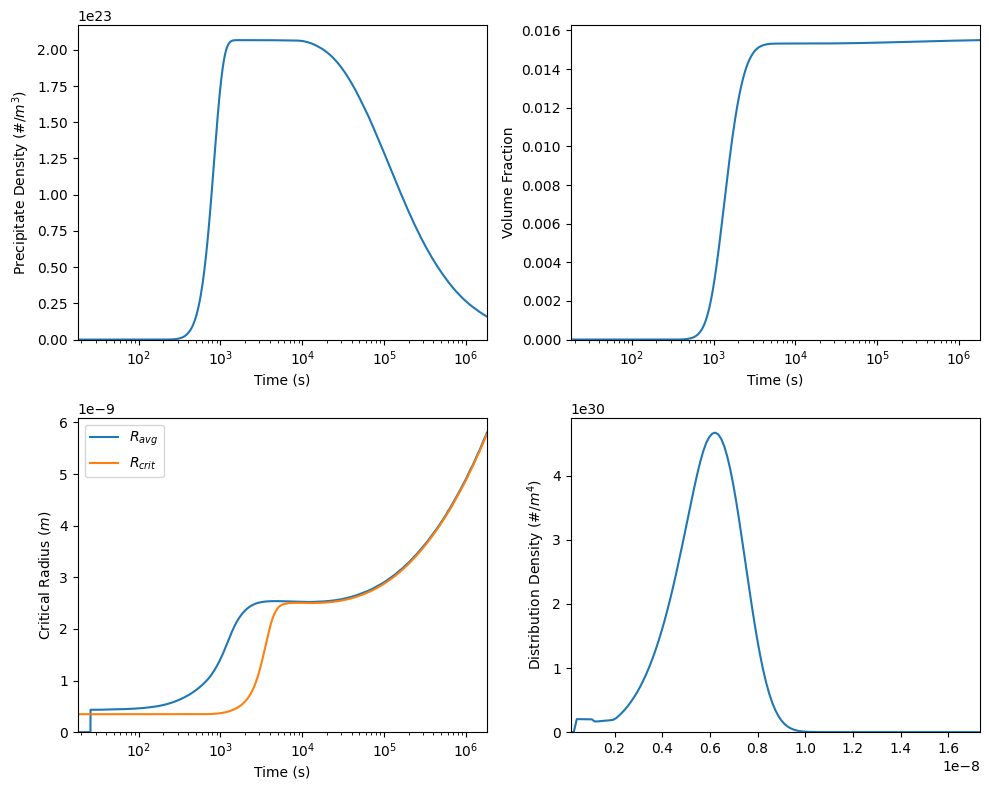

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from kawin.precipitation.Plot import plotPrecipitateResults

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

plotPrecipitateResults(model, 'precipitate density', ax=axes[0,0])
plotPrecipitateResults(model, 'volume fraction', ax=axes[0,1])
plotPrecipitateResults(model, 'average radius', ax=axes[1,0], label=r'$R_{avg}$')
plotPrecipitateResults(model, 'critical radius', ax=axes[1,0], label=r'$R_{crit}$')
axes[1,0].legend()
plotPrecipitateResults(model, 'pdf', ax=axes[1,1])

fig.tight_layout()

## Saving

The data in the model can be saved into a numpy .npz format

```
PrecipitateModel.save(filename)
```

<br>

Since only the data is saved, to load the data back in, the model is to be initialized, then the data can be loaded into the model

```
model = PrecipitateModel(...)
model.load(filename)
```

## References

1. A. T. Dinsdale, "SGTE Data for Pure Elements" *Calphad* 15 (1991) p. 317
2. T. Wang, Z. Jin and J. Zhao, “Thermodynamic Assessment of the Al-Zr Binary System” *Journal of Phase Equilibria* 22 (2001) p. 544
3. J. D. Robson and P. B. Prangnell, “Dispersoid Precipitation and Process Modeling in Zirconium Containing Commercial Aluminum Alloys” *Acta Materialia* 49 (2001) p. 599